<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/ConvolutionalStyleTransferExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Yi Lin(Kyle) Gao





##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [9]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [10]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


In [11]:
def load_img(path):
  max_dim = 512
  img = tf.io.read_file(path) #iostream string
  img = tf.image.decode_image(img,channels=3) #(x,y,3) uint8
  img = tf.image.convert_image_dtype(img,tf.float32)

  shape = tf.cast(tf.shape(img)[:-1],tf.float32) #[x,y]
  long_dim = max(shape)
  scale = max_dim / long_dim 
  new_shape = tf.cast(shape*scale, tf.int32)
  img = tf.image.resize(img,new_shape)
  img = img[tf.newaxis,:] #(1,x,y,3)
  return img


In [12]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [13]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

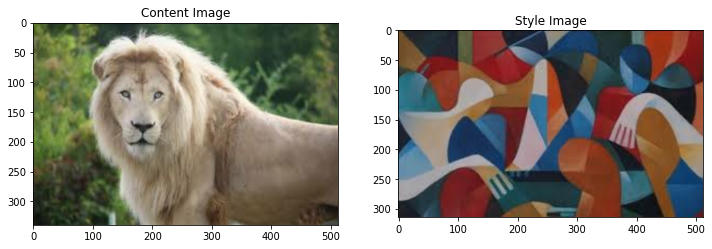

In [134]:
style_path = "AbstractMozaic.jpg"
content_path = "lion.jpg"
content_image = load_img(content_path)
style_image= load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

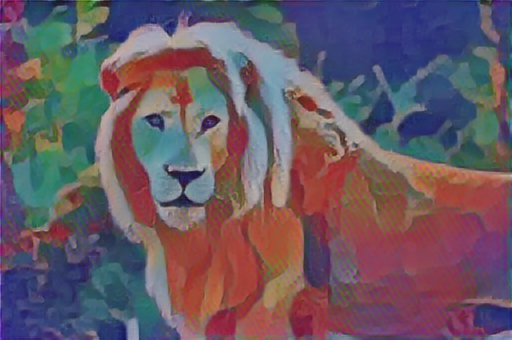

In [135]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

#We will try style transfer on ResNet50

In [33]:
x = tf.image.resize(x,(224,224))

In [53]:
res = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

print()
for layer in res.layers:
  print(layer.name)


input_12
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv

In [65]:
content_layers = ['conv5_block2_2_conv',
                  'conv5_block3_3_conv']
style_layers =  ['conv1_conv',
                 'conv2_block1_1_conv',
                'conv2_block2_3_conv',
                'conv2_block3_3_conv',
                'conv3_block1_1_conv', 
                'conv3_block2_3_conv', 
                'conv4_block1_1_conv',
                'conv4_block3_3_conv']

In [66]:
def res_layers(layer_names):
  res = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
  res.trainable = False
  outputs = [res.get_layer(layer).output for layer in layer_names] #<tf.Tensor 'block1_conv1/Relu_2:0' shape=(None, None, None, 64) dtype=float32>
  #without hub.KerasLayer, get Layer.output and create a keras.Model with .input,.output
  model = tf.keras.Model([res.input],outputs)
  return model

In [140]:
style_path = "AbstractMozaic.jpg"
content_path = "lion.jpg"
content_image = load_img(content_path)
style_image= load_img(style_path)

In [116]:
style_extractor = res_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Gram matrix G 

gives the inner product of a set of vector

$G_{ij} = \langle\, v_i,v_j\rangle$

The Gram matrix of a layer is the normalized inner product (over the pixel height,width indices labeled by ij) 

The Gram matrix has dimensions (channel, channel)

$G^l_{cd} = \frac{1}{IJ}\sum_{ij} F^l_{ijc}(x) F^l_{ijd}(x)$

In [117]:
def gram_matrix(tensor):
  result = tf.einsum('lijc,lijd->lcd',tensor,tensor)
  input_shape = tf.shape(tensor)
  norm = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/norm

In [118]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.res =  res_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.res.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = inputs
    outputs = self.res(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    #dictionary of tensor output by keyed by layer name
    content_dict = {content_name:value 
                    for content_name, value 
     
                    in zip(self.content_layers, content_outputs)}

    #dictionary of gram matrices keyed by layer name
    style_dict = {style_name:value
                  for style_name, value 
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [119]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))
print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)


Styles:
   conv1_conv
    shape:  (1, 64, 64)

   conv2_block1_1_conv
    shape:  (1, 64, 64)

   conv2_block2_3_conv
    shape:  (1, 256, 256)

   conv2_block3_3_conv
    shape:  (1, 256, 256)

   conv3_block1_1_conv
    shape:  (1, 128, 128)

   conv3_block2_3_conv
    shape:  (1, 512, 512)

   conv4_block1_1_conv
    shape:  (1, 256, 256)

   conv4_block3_3_conv
    shape:  (1, 1024, 1024)

Contents:
   conv5_block2_2_conv
    shape:  (1, 11, 16, 512)
   conv5_block3_3_conv
    shape:  (1, 11, 16, 2048)


We want to optimize an image whose style gram matrices are as close as possible to that of style_image, and content output is as close as possible to content_image.

In [120]:

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [136]:
def style_content_loss(outputs):
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    """Mean square loss of style matrices summed over all style layers"""
    style_loss = tf.reduce_sum([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    """Mean square loss of content layer outputs summed over all content layers"""
    content_loss = tf.reduce_sum([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

total_variation_weight = 0.05

In [137]:
optimizer = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)



@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs) 
    loss += total_variation_weight*tf.image.total_variation(image) #this smooths out the image

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [138]:
image = tf.Variable(content_image) #running gradient descent on this
style_weight=1e-2
content_weight=1e4

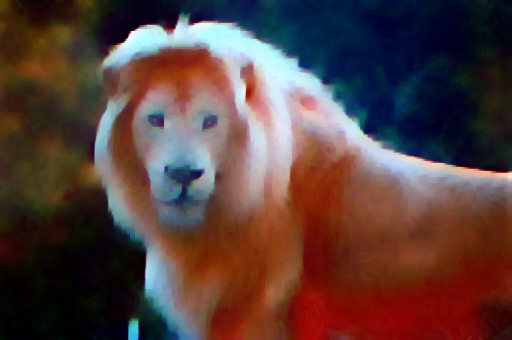

Train step: 500
Total time: 24.7


In [139]:
import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

It seems the features in the conv layers of ResNet50 manifested more locally than those of Vgg16 and the tf_hub style transfer model.